# A simple example of generating playlist by multilable learning

In [1]:
%matplotlib inline

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = 'data'
faotm = os.path.join(data_dir, 'aotm-2011/aotm-2011-subset.pkl')
fmap  = os.path.join(data_dir, 'aotm-2011/map_song_track.pkl')
ftag  = os.path.join(data_dir, 'msd/msd_tagtraum_cd2c.cls')

## Data loading

Load playlists.

In [3]:
playlists = pkl.load(open(faotm, 'rb'))

In [4]:
print('#Playlists: %d' % len(playlists))

#Playlists: 241


In [5]:
playlists[0]

{'category': 'Road Trip',
 'filtered_lists': [['SOYXQBU12CF5F88FAA',
   'SOYDNDN12A58A77663',
   'SOOLDQA12A6D4F9370',
   'SOHCPBA12AB018377B',
   'SOHGHSU12AB0186C5F',
   'SOFRCHU12A8C13F96B',
   'SONHAWL12A6310F260',
   'SOXRJWV12A8C13DE1D',
   'SOUPNVN12AB018B0B4',
   'SOEYNQL12A67ADE655',
   'SOZTMFN12A58A7DCEE',
   'SORDYVO12A8C141A40']],
 'mix_id': 113009,
 'playlist': [[['Simon & Garfunkel', 'America'], 'SOYXQBU12CF5F88FAA'],
  [['Marc Cohn', 'Walking In Memphis'], 'SOYDNDN12A58A77663'],
  [['Matt Pond PA', 'Lily Two'], 'SOOLDQA12A6D4F9370'],
  [['Grateful Dead', 'Tennessee Jed'], 'SOHCPBA12AB018377B'],
  [['Braid', 'Killing a Camera'], 'SOHGHSU12AB0186C5F'],
  [['Johnny Cash', 'Hey Porter'], 'SOFRCHU12A8C13F96B'],
  [["Marcy's Playground", 'Memphis'], 'SONHAWL12A6310F260'],
  [['Whiskeytown', 'Lo-Fi Tennessee Mountain Angel'], 'SOXRJWV12A8C13DE1D'],
  [['Something Corporate', 'I Woke Up in a Car'], 'SOUPNVN12AB018B0B4'],
  [['The Boy Least Likely To',
    "I'm Glad I Hitched My

In [6]:
print('#Songs: %d' % len({songID for p in playlists for songID in p['filtered_lists'][0]}))

#Songs: 1718


In [7]:
lengths = [len(p['filtered_lists'][0]) for p in playlists]
#plt.hist(lengths, bins=20)
print('Average playlist length: %.1f' % np.mean(lengths))

Average playlist length: 9.2


Load `song_id` --> `track_id` mapping: a song may correspond to multiple tracks.

In [8]:
song2TrackID = pkl.load(open(fmap, 'rb'))

In [9]:
{ k : song2TrackID[k] for k in list(song2TrackID.keys())[:10] }

{'SOCXCXO12A58A7942F': ['TRCKHHS128F145A92B'],
 'SOETUOD12AB0185397': ['TRRABGF128F4252E44', 'TRISYYV128F932E74E'],
 'SOKBQUE12AB0182216': ['TREBZDS128F93269FA'],
 'SOKOXWU12AF72AD1BC': ['TREWTIO128F145497E', 'TRKLEJT128E078EC6C'],
 'SOLKFRC12B0B8077F7': ['TRSOLCZ128F4263C79'],
 'SOPLQEW12A679D8AC1': ['TRAWMXO128E0792DDE'],
 'SOUVSTM12A8AE48BC8': ['TRGDLXQ128F4260C69'],
 'SOXTOUC12AB0185A31': ['TRBYVRH128F935189A'],
 'SOYIPFY12A8C13AF8C': ['TRQUYED128F428B49C'],
 'SOYZGMB12A8AE487F1': ['TRZCSSL128F426F89C']}

Load song tags, build `track_id` --> `tag` mapping.

In [10]:
track2Tags = dict()

In [11]:
with open(ftag) as f:
    for line in f:
        if line[0] == '#': continue
        tid, tag = line.strip().split('\t')
        #print(tid, tag)
        track2Tags[tid] = tag

In [12]:
print('#(Track, Tag): %d' % len(track2Tags))

#(Track, Tag): 191401


In [13]:
{ k : track2Tags[k] for k in list(track2Tags.keys())[:10] }

{'TRCMDRR128F9301A9A': 'Rap',
 'TRFRCRL128F93011CD': 'Electronic',
 'TRIMYCU128E07896B3': 'Rock',
 'TRPHTAC12903CC583F': 'Electronic',
 'TRSIHJY128F933A29D': 'Rock',
 'TRTEOGC128F14895C2': 'Pop',
 'TRUIKPC128C7196C73': 'Rock',
 'TRVMGPT12903CAA0C5': 'Blues',
 'TRVOJZQ128F427054E': 'Electronic',
 'TRWXFFH128F4274E55': 'Rock'}

## Data cleaning

Use the subset of playlist such that the first song (i.e. the *seed* song) in each playlist has tag(s).

In [14]:
subset_ix = []

In [89]:
seedSong2Tag = { }
for ix in range(len(playlists)):
    # the list of song IDs in the playlist
    songIDs = playlists[ix]['filtered_lists'][0]

    # seed song
    seedSongID   = songIDs[0]
    seedTrackIDs = song2TrackID[seedSongID]
    
    # make sure that at least one track for the song has a corresponding tag
    flag = [ (trackID in track2Tags) for trackID in seedTrackIDs]
    if not np.any(flag):
        continue

    seedSong2Tag[playlists[ix]['mix_id']] = [ track2Tags[seedTrackIDs[i]] for i in range(0, len(flag)) if flag[i] == True  ]

    subset_ix.append(ix)

In [91]:
#seedSong2Tag

In [16]:
playlists_subset = [playlists[ix] for ix in subset_ix]

In [17]:
print('#Playlists used: %d' % len(subset_ix))

#Playlists used: 130


The set of unique songs, **in multilabel learning, we have a label for each song in this set**.

In [18]:
song_set = sorted({songID for p in playlists_subset for songID in p['filtered_lists'][0]})

In [19]:
print('#Songs used: %d' % len(song_set))

#Songs used: 927


In [20]:
print(song_set[:10])

['SOAAFAC12A67ADF7EB', 'SOAAJWZ12A67AE16FB', 'SOABLRM12A6701F091', 'SOADISH12AB018DFAC', 'SOADQHJ12AF729D75C', 'SOAGENT12A8C1363D1', 'SOAGGRW12A6D4F920E', 'SOAGSYE12A58A7A5A7', 'SOAHSMI12AF72A9FA7', 'SOAJJRO12AB0182B3A']


## Data analysis

For the most part, playlists contain less than 10 songs. The most common playlist length is 2 songs.

Average playlist length: 9.1


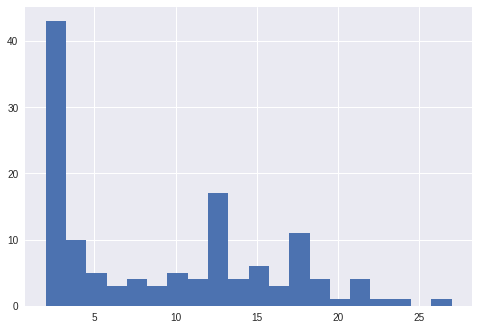

In [21]:
playlist_lengths = [len(playlist['filtered_lists'][0]) for playlist in playlists_subset]
plt.hist(playlist_lengths, bins=20)
print('Average playlist length: %.1f' % np.mean(playlist_lengths))

`Song_id --> Song_name` mapping.

In [22]:
songID2Name = {s[1]: s[0] for p in playlists_subset for s in p['playlist']}

In [23]:
#songID2Name

## One-hot tag encoding

Indicator of tags: `tag` --> `index` mapping.

In [24]:
# the set of unique tags
tag_set = sorted(set(track2Tags.values()))

In [25]:
print('#Tags: %d' % len(tag_set))

#Tags: 15


In [26]:
tag_indicator = { tag: ix for ix, tag in enumerate(tag_set) }

In [27]:
tag_indicator

{'Blues': 0,
 'Country': 1,
 'Electronic': 2,
 'Folk': 3,
 'Jazz': 4,
 'Latin': 5,
 'Metal': 6,
 'New Age': 7,
 'Pop': 8,
 'Punk': 9,
 'Rap': 10,
 'Reggae': 11,
 'RnB': 12,
 'Rock': 13,
 'World': 14}

## Feature extraction

Build features (1-hot encoding of tag) for a song given its `song_id`.

In [28]:
def gen_features(song_id, song2TrackID = song2TrackID, tag_indicator = tag_indicator):
    """
        Generate one-hot feature vector for a given song ID
    """

    features = np.zeros(len(tag_set), dtype = np.float)
    trackIDs = song2TrackID[song_id]

    cnt = 0
    for trackID in trackIDs:
        if trackID in track2Tags:
            cnt += 1
            tag = track2Tags[trackID]
            tag_ix = tag_indicator[tag]
            features[tag_ix] = 1

    # must have at least one tag for the song, else useless
    assert(cnt >= 1)

    return features

In [29]:
def gen_feature_map(song_id, seed):
    """
        Generate feature mapping for a given (label, query) pair
    """
    
    #return gen_features(song_id) - gen_features(seed)  # feature map
    return gen_features(seed)  # a trivial feature map

In [30]:
def gen_training_set(label_ix, playlists = playlists_subset, song_set = song_set):
    """
        Create the labelled dataset for a given song index
        
        Input:
            - label_ix: song index, number in { 0, ..., # songs }
            - playlists: which playlists to create features for
            
        Output:
            - (Feature, Label) pair (X, y), with # num playlists rows
              X comprises the features for each seed song and the given song
              y comprises the indicator of whether the given song is present in the respective playlist
    """

    assert(label_ix >= 0)
    assert(label_ix < len(song_set))

    N = len(playlists)
    d = len(tag_set)

    X = np.zeros((N, d), dtype = np.float)
    y = np.zeros(N, dtype = np.float)
    
    whichSong = song_set[label_ix]
    
    for i in range(len(playlists)):
        playlist = playlists[i]['filtered_lists'][0]
        seed     = playlist[0]

        X[i,:] = gen_feature_map(whichSong, seed)
        y[i]   = int(whichSong in playlist)

    return X, y

In [31]:
gen_feature_map(song_set[100], playlists_subset[0]['filtered_lists'][0][0])

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.])

## Training & Testing

Train a logistic regression model for each label.

In [32]:
classifiers = [LogisticRegression(class_weight='balanced') for i in range(len(song_set))]

In [75]:
allPreds  = [ ]
allTruths = [ ]
coefMat = [ ]
labelIndices = [ ]

Y = np.NAN * np.ones((len(playlists_subset), len(song_set)))

for label_ix in range(len(song_set)):
    X, y = gen_training_set(label_ix)
    Y[:,label_ix] = y
    
    # by fixing random seed, the same playlists will be in the test set each time
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, \
                                                                           test_size = 0.33, \
                                                                           random_state = 31)    
    
    if np.max(y_train) == 0.0: # or np.max(y_test) == 0.0:
        continue

    classifiers[label_ix].fit(X_train, y_train)
    
    allPreds.append(classifiers[label_ix].decision_function(X_test))
    allTruths.append(y_test)    

    coefMat.append(classifiers[label_ix].coef_.reshape(-1))
    labelIndices.append(label_ix)
    #print(classifiers[label_ix].coef_)
    #print(classifiers[label_ix].intercept_)

In [76]:
allPreds = np.array(allPreds).T
allTruths = np.array(allTruths).T

print(allPreds.shape)
print(allTruths.shape)

(43, 699)
(43, 699)


## Evaluation

Compute AUC.

Average AUC: 0.6577


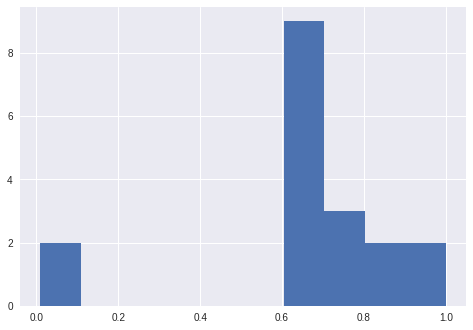

In [35]:
aucs = [ ]
for i in range(0,allPreds.shape[0]):
    pred  = allPreds[i,:]
    truth = allTruths[i,:]
    
    if np.max(truth) == 0.0:
        continue
    
    aucs.append(sk.metrics.roc_auc_score(truth, pred))
    
print('Average AUC: %1.4f' % np.mean(aucs))
plt.hist(aucs, bins = 10);

Compute average precision.

## Result analysis

Coefficient matrix `(#Genres, #Songs)`.

In [36]:
coefMat = np.array(coefMat).T

In [37]:
coefMat.shape

(15, 699)

In [38]:
#sns.heatmap(coefMat[:, :30])

Top 10 songs of each genre (w.r.t.) the coefficients.

In [39]:
labelIndices = np.array(labelIndices)

In [65]:
Top10Songs_ix = [ ]
for i in range(coefMat.shape[0]):
    ix = np.argsort(coefMat[i, :])[::-1][:10]
    Top10Songs_ix.append(labelIndices[ix])
    
Bot10Songs_ix = [ ]
for i in range(coefMat.shape[0]):
    ix = np.argsort(coefMat[i, :])[:10]
    Bot10Songs_ix.append(labelIndices[ix])

In [41]:
#Top10Songs_ix

In [42]:
#np.array(song_set)[Top10Songs_ix[0]]

In [68]:
cols = ['Genre.Count'] + ['Top %d' % k for k in range(1, 11)] + ['Bot %d' % k for k in range(1, 11)]
Top10Songs = pd.DataFrame(np.zeros((len(tag_set), 21), dtype = object),
                          index = tag_set, columns = cols)

In [96]:
# number of appearances of playlists with each genre
S = X.sum(axis = 0)
idx = np.argsort(S)[::-1]
#[(tag_set[i], S[i]) for i in idx]

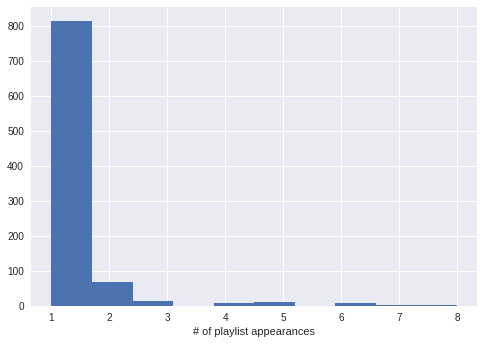

In [98]:
# number of appearances of each song in a playlist
plt.hist(Y.sum(axis = 0));
plt.xlabel('# of playlist appearances');

In [70]:
for i in range(len(tag_set)):
    row = tag_set[i]
    Top10Songs.loc[row, 'Genre.Count'] = S[i]
    for j in range(10):
        song_ix = Top10Songs_ix[i][j]
        songID = song_set[song_ix]
        songName = (songID, songID2Name[songID][0], songID2Name[songID][1])
        col = 'Top %d' % (j+1)
        Top10Songs.loc[row, col] = songName
        
        song_ix = Bot10Songs_ix[i][j]
        songID = song_set[song_ix]
        songName = (songID, songID2Name[songID][0], songID2Name[songID][1])        
        col = 'Bot %d' % (j+1)
        Top10Songs.loc[row, col] = songName        
        
Top10Songs = Top10Songs.sort_values(['Genre.Count'], ascending=False)

In [73]:
Top10Songs.head(5)

,Genre.Count,Top 1,Top 2,Top 3,Top 4,Top 5,Top 6,Top 7,Top 8,Top 9,...,Bot 1,Bot 2,Bot 3,Bot 4,Bot 5,Bot 6,Bot 7,Bot 8,Bot 9,Bot 10
Rock,98,"(SOTSCKX12AB01857AA, , Electioneering)","(SOVVJWQ12A58A7B38C, Radiohead, Polyethylene [...","(SOWKEUN12AF72AB837, Radiohead, Climbing Up Th...","(SOYQAVD12D02193D04, radiohead, paranoid android)","(SOALITF12A6310DFCD, radiohead, just)","(SOADISH12AB018DFAC, Radiohead, Talk Show Host...","(SOGBLMI12AB01856AC, Radiohead, Fitter Happier)","(SOBMAFJ12A8C137C88, radiohead, street spirit ...","(SOPRZQA12A58A7A112, radiohead, black star)",...,"(SOETHJA12A6310F21E, damien rice, volcano)","(SOXTQLJ12A6D4F6C2B, michelle branch, where ar...","(SOLWTFI12A6D4F66E1, something corporate, space)","(SOXAFQB12A6D4F476F, yellowcard, way away)","(SOZPMAS12A67020917, 3 doors down, changes)","(SOMYCHS12A67020918, 3 doors down, going down ...","(SOZAASU12A6D4FA90C, matchbox twenty, busted (...","(SOYZGMB12A8AE487F1, chevelle, the red)","(SOMRZMI12A6D4F8F25, linkin park, numb)","(SOCQJYB12AB017E855, trapt, headstrong)"
Electronic,7,"(SOSANGX12AB0181C93, Depeche Mode, Wrong)","(SOCSVVA12AB0186D97, , Walking In My Shoes)","(SORLZFM12AF729FB69, dogs die in hot cars, god...","(SONGIXY12A58A7BB42, LCD Soundsystem, Someone ...","(SONNSYV12A8C146BEC, modest mouse, float on)","(SOOCEKO12A67ADF6D9, morcheeba, part of the pr...","(SOOQQDQ12A8AE47CA9, beth orton, central reser...","(SOOTEAB12A67ADF7E9, morcheeba, let me see)","(SOPMCUN12A6701F456, happy mondays, 24 hour pa...",...,"(SOHWRJH12A8C139AFC, air, playground love)","(SOPPJWS12AC96184C3, Sugar Ray, Every Morning)","(SOIPYPB12A8C1360D4, evanescence, my immortal)","(SOLWTFI12A6D4F66E1, something corporate, space)","(SOETHJA12A6310F21E, damien rice, volcano)","(SOXTQLJ12A6D4F6C2B, michelle branch, where ar...","(SOZPMAS12A67020917, 3 doors down, changes)","(SOZAASU12A6D4FA90C, matchbox twenty, busted (...","(SOMRZMI12A6D4F8F25, linkin park, numb)","(SOCQJYB12AB017E855, trapt, headstrong)"
Folk,7,"(SOLWTFI12A6D4F66E1, something corporate, space)","(SOXTQLJ12A6D4F6C2B, michelle branch, where ar...","(SOETHJA12A6310F21E, damien rice, volcano)","(SOMRZMI12A6D4F8F25, linkin park, numb)","(SOCQJYB12AB017E855, trapt, headstrong)","(SOAPEXU12A58A792BE, fuel, falls on me)","(SOMYCHS12A67020918, 3 doors down, going down ...","(SOYZGMB12A8AE487F1, chevelle, the red)","(SOZAASU12A6D4FA90C, matchbox twenty, busted (...",...,"(SOHWRJH12A8C139AFC, air, playground love)","(SOPPJWS12AC96184C3, Sugar Ray, Every Morning)","(SOEUIUI12A58A7CD98, Pink Floyd, Money)","(SOIIVGZ12A8C1320CF, Incubus, Pardon Me)","(SOYJRZE12AB0184261, Velvet Underground, Heroin)","(SOMIXXT12D021B27DE, system of a down, spiders)","(SOWGGXF12CF5F8716C, Christina Aguilera, Fighter)","(SOBATNA12B0B80758F, res, i've known the garden)","(SOMUCFP12A6701F28E, faye wong, (can't read so...","(SOBMQVM12A81C2070D, bjork, it's not up to you)"
Pop,7,"(SOWGGXF12CF5F8716C, Christina Aguilera, Fighter)","(SOMTXSB12AF72ACC38, Britney Spears, Oops I Di...","(SOGEDPI12A58A79FC1, Spice Girls, Wannabe)","(SOKKHNX12AB01801B7, Michelle Branch, You Get Me)","(SOSVUIU12A8AE4629D, Christina Aguilera, Impos...","(SOYIBFQ12A6701C628, Christina Aguilera, Lady ...","(SOYFLSE12D021936ED, Lil Wayne, A Milli)","(SOYDXJI12B350583CE, Christina Aguilera, Beaut...","(SOXGPDZ12A6D4FAAA7, Nick Lachey, I Swear)",...,"(SOHWRJH12A8C139AFC, air, playground love)","(SOIPYPB12A8C1360D4, evanescence, my immortal)","(SOMIXXT12D021B27DE, system of a down, spiders)","(SOIIVGZ12A8C1320CF, Incubus, Pardon Me)","(SOYJRZE12AB0184261, Velvet Underground, Heroin)","(SOEUIUI12A58A7CD98, Pink Floyd, Money)","(SOETHJA12A6310F21E, damien rice, volcano)","(SOLWTFI12A6D4F66E1, something corporate, space)","(SOXTQLJ12A6D4F6C2B, michelle branch, where ar...","(SOCQJYB12AB017E855, trapt, headstrong)"
Rap,5,"(SOGDTEM12A8C13D215, Cypress Hill, How I Could...","(SOXVSVZ12A8C131EC2, Cypress Hill, Kronologik)","(SOQYQGQ12A8C134FF4, Cypress Hill, What's Your...","(SOWSKFO12D02193

In [93]:
rapPlaylists = [ k for k in seedSong2Tag if 'Rap' in seedSong2Tag[k] ]

In [95]:
[ p['playlist'] for p in playlists_subset if p['mix_id'] in rapPlaylists ]

[[[['black eyed peas', 'hey mama'], 'SOVMGXI12AF72A80B0'],
  [['black eyed peas', 'shut up'], 'SOSOVYB12AB01845F0'],
  [['evanescence', 'bring me to life'], 'SOFPHXA12A8C14517E']],
 [[['Eminem', 'Stan'], 'SOSWVGI12D02194007'],
  [['Eminem', 'The way I am'], 'SOQRRHL12AB017A67C'],
  [['Britney Spears', 'Lucky'], 'SORSOAK12A8C133AB7'],
  [['Eminem', 'Slim Shady'], 'SOKOXWU12AF72AD1BC']],
 [[['one', 'one'], 'SOJMJBC12AB0181E46'],
  [['one', 'one'], 'SOJMJBC12AB0181E46'],
  [['one', 'one'], 'SOJMJBC12AB0181E46'],
  [['one', 'one'], 'SOJMJBC12AB0181E46']],
 [[['Cypress Hill', 'Hand On The Pump'], 'SONETQF12A8C140099'],
  [['Cypress Hill', 'Latin Lingo'], 'SOSJVIK12A58A7E22C'],
  [['Cypress Hill', 'How I Could Just Kill A Man'], 'SOGDTEM12A8C13D215'],
  [['Cypress Hill', 'Lick A Shot'], 'SOJVNNI12AB0186FD1'],
  [['Cypress Hill', 'Cock The Hammer'], 'SOWWVNU12AC3DFB625'],
  [['Cypress Hill', "I Ain't Goin Out Like That"], 'SOLPNNW12A8C140254'],
  [['Cypress Hill', 'Make A Move'], 'SOLZXJE12A8